# A joint Density for FX Rates from Observed Cross-Smiles

### Author | Max Chellew

## Libarys

In [2]:
## Import Python Libarys

# Libarys
import numpy as np 
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt

## Randomizor Seed

In [3]:
np.random.seed(2001)

## Data

In [4]:
## Create Dataframe

# Forward Price Data [libary]
FPD = {"EUR/USD": np.array([1.0903]),
       "GBP/USD": np.array([1.2738]),
       "EUR/GBP": np.array([0.85590])}

# Strike Price Data [libary]
SPD = {"EUR/USD": np.array([1.0681, 1.0791, 1.0904, 1.1014, 1.1119]),
       "GBP/USD": np.array([1.2456, 1.2595, 1.274, 1.2883, 1.3017]),
       "EUR/GBP": np.array([0.84386, 0.84969, 0.85585, 0.86234, 0.86875])}

# Implied Volatility Data [libary]
IVD = {"EUR/USD": np.array([0.0554, 0.053115, 0.0516, 0.051435, 0.0523]),
       "GBP/USD": np.array([0.06055, 0.058665, 0.0573, 0.057185, 0.05765]),
       "EUR/GBP": np.array([0.03809, 0.03725, 0.037225, 0.03825, 0.03986])}

# Forward price, Strike price, Implied volatility data [pandas DataFrame]
data = pd.DataFrame(data=[FPD, SPD, IVD], index=["Forward", "Strike", "Implied Vol"])

# Display dataframe
display(data)

,EUR/USD,GBP/USD,EUR/GBP
Forward,[1.0903],[1.2738],[0.8559]
Strike,"[1.0681, 1.0791, 1.0904, 1.1014, 1.1119]","[1.2456, 1.2595, 1.274, 1.2883, 1.3017]","[0.84386, 0.84969, 0.85585, 0.86234, 0.86875]"
Implied Vol,"[0.0554, 0.053115, 0.0516, 0.051435, 0.0523]","[0.06055, 0.058665, 0.0573, 0.057185, 0.05765]","[0.03809, 0.03725, 0.037225, 0.03825, 0.03986]"


## SVI parametrization

SVI implied volaitlity $ \hat{\sigma}(K)$ is defined by the SVI implied variance

$$ \hat{\sigma}(K)^2 T = a + b\Big(\rho(x-m) + \sqrt{(x-m)^2 + \sigma^2}\Big) $$

we can fit the SVI parmaters $a, b, m, \rho, \sigma$ to the observed cross smiles by minimising the following least sqaures problem

Let:

$$f(x_i, \beta) = \hat{\sigma}(K)^2 T = a + b\Big(\rho(x-m) + \sqrt{(x-m)^2 + \sigma^2}\Big)$$

where $x_i = \log(\frac{K_i}{F_0})$ and $\beta = (a, b, m, \rho, \sigma)$

Minimise:

$$  F(X, Y, \beta) = \sum^{n}_{i=1} (f(x_i, \beta) - y_i)^2 $$

where $X = (x_1, ..., x_n)$ are the log moneyness values and $Y = (y_1, ..., y_n)$ are the observed cross implied variance values 

Constraints: 

$$ 
\begin{aligned}

\sigma &\geq 0   \\

b &\geq 0 \\

|\rho| &\leq 1 \\

a + b\sigma \sqrt{1 - \rho^{2}} &\geq 0

\end{aligned}
$$

SVI functions

In [5]:
## SVI implied variance and implied volatility functions

# Implied Variance [function]
def impVar(F, K, a, b, m, rho, sigma):

    # initalize variables
    x = np.log(K/F)

    # return Implied variance
    return a + b*(rho*(x-m) + np.sqrt((x-m)**2 + sigma**2))

# Implied Volatility (sigma hat) [function]
def impVol(F, K, T, prm):

    # return implied volatility
    return np.sqrt((1/T)*impVar(F, K, *prm))

In [6]:
## SVI Parameter Calibaration [set-Up]

# Least squares residuals [function]
def res(x_, F, K, y):

    # Initalize variables
    a = x_[0]
    b = x_[1]
    m = x_[2]
    rho = x_[3]
    sigma = x_[4]
    x = np.log(K/F)

    # return residual value
    return (a + b*(rho*(x - m) + np.sqrt((x - m)**2 + sigma**2))) - (y**2)*(1/12)

# SVI calibaration via least squared estimation [function]
def calibarationSVI(data):

    # Inital Parameter Guess
    p0 = [0, 0, 0, 0, 0]

    # Set input values
    F = data.iloc[0][0]
    K = data.iloc[1]
    y = data.iloc[2]

    # least squared minimisation
    prm_guess = sp.optimize.least_squares(res, p0, args=(F, K, y), bounds=([0, 0, -np.inf, -1, 0], [np.inf, np.inf, np.inf, 1, np.inf]), method="dogbox")

    # return parameter guess
    return prm_guess.x

Return SVI parameters

In [7]:
## SVI calibaration [exetution]

# Set SVI parameters [arrays]
prm_EURUSD = calibarationSVI(data["EUR/USD"])
prm_GBPUSD = calibarationSVI(data["GBP/USD"])
prm_EURGBP = calibarationSVI(data["EUR/GBP"])

# SVI parmaeters [pandas DataFrame]
prm = pd.DataFrame(data = {"EUR/USD": prm_EURUSD,
                           "GBP/USD": prm_GBPUSD,
                           "EUR/GBP": prm_EURGBP}, 
                           index=["a", "b", "m", "rho", "sigma"])

# Display SVI calibrated SVI parameters
display(prm)

,EUR/USD,GBP/USD,EUR/GBP
a,0.000174,0.000258,0.000089
b,0.002357,0.001314,0.001832
m,0.002396,0.000132,-0.002134
rho,-0.191958,-0.473847,0.093025
sigma,0.019752,0.011821,0.014137


Plot SVI smiles along with market impled volatility

In [8]:
## Inialize strike and forward prices

# Strike prices (rates) [arrays]
KX = np.linspace(min(data.loc["Strike", "EUR/USD"]), max(data.loc["Strike", "EUR/USD"]), 30)
KY = np.linspace(min(data.loc["Strike", "GBP/USD"]), max(data.loc["Strike", "GBP/USD"]), 30)
KZ = np.linspace(min(data.loc["Strike", "EUR/GBP"]), max(data.loc["Strike", "EUR/GBP"]), 30)

# Forward prices (rates) [variables]
FX = data.loc["Forward", "EUR/USD"][0]
FY = data.loc["Forward", "GBP/USD"][0]
FZ = data.loc["Forward", "EUR/GBP"][0]

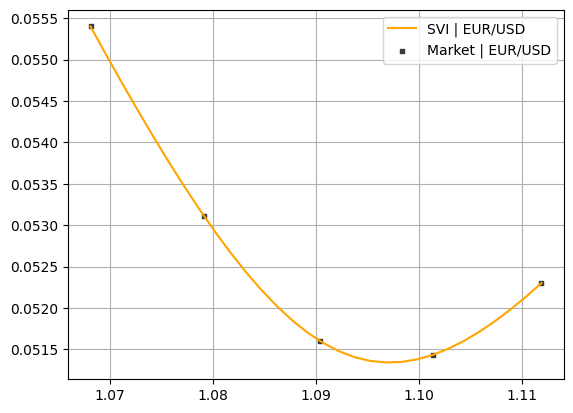

In [9]:
# EUR/USD SVI smile plot [plot]

plt.grid()
plt.plot(KX, impVol(FX, KX, 1/12, prm["EUR/USD"]), zorder=2, color="orange")
plt.scatter(data.loc["Strike", "EUR/USD"], data.loc["Implied Vol", "EUR/USD"], marker="s", s=12.5, color="#3b3b3b", zorder=1)
plt.legend(["SVI | EUR/USD", "Market | EUR/USD"], fontsize=10.5)
plt.xlabel("ModifedStrike Rate", fontsize=10.5)
plt.ylabel("Implied Volatility", fontsize=10.5)

plt.savefig('EU_SVI_Mkt.png')

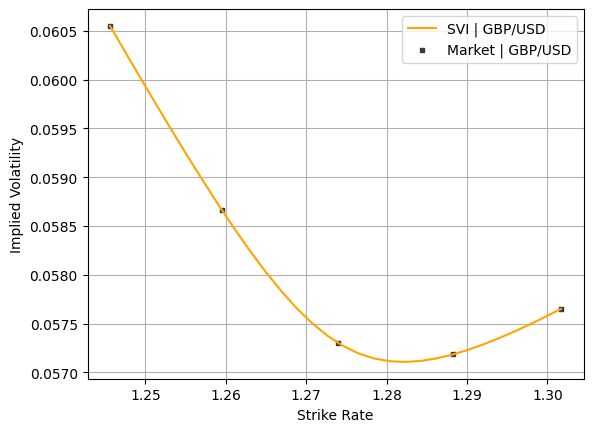

In [10]:
## GBP/USD SVI smile [plot]

plt.grid()
plt.plot(KY, impVol(FY, KY, 1/12, prm["GBP/USD"]), zorder=2, color="orange")
plt.scatter(data.loc["Strike", "GBP/USD"], data.loc["Implied Vol", "GBP/USD"], marker="s", s=12.5, color="#3b3b3b", zorder=1)
plt.legend(["SVI | GBP/USD", "Market | GBP/USD"], fontsize=10.5)
plt.xlabel("Strike Rate", fontsize=10.5)
plt.ylabel("Implied Volatility", fontsize=10.5)

plt.savefig('GU_SVI_Mkt.png')

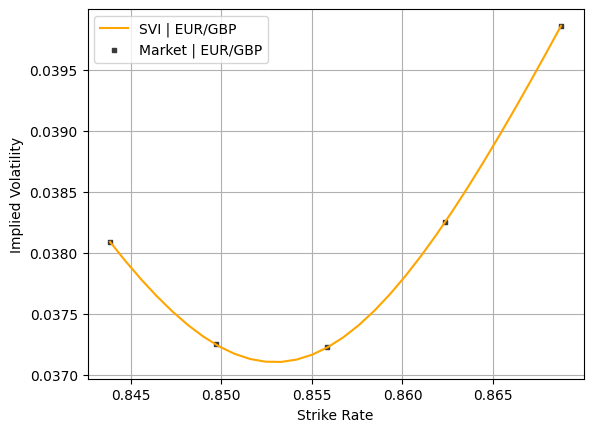

In [11]:
# EUR/GBP SVI smile [plot]
plt.grid()
plt.plot(KZ, impVol(FZ, KZ, 1/12, prm["EUR/GBP"]), zorder=2, color="orange")
plt.scatter(data.loc["Strike", "EUR/GBP"], data.loc["Implied Vol", "EUR/GBP"], marker="s", s=12.5, color="#3b3b3b", zorder=1)
plt.legend(["SVI | EUR/GBP", "Market | EUR/GBP"], fontsize=10.5)
plt.xlabel("Strike Rate", fontsize=10.5)
plt.ylabel("Implied Volatility", fontsize=10.5)

plt.savefig('EG_SVI_Mkt.png')

## Risk-Neural Densities

In [12]:
## Black-Scholes Based Functions

# Black Scholes Call option price [function]
def bsCall(St, K, tau, sigma, r):

    # Set d1 and d2 values
    d1=(1/(sigma*np.sqrt(tau)))*(np.log(St/K)+(r + 0.5*sigma**2)*(tau))
    d2=d1-sigma*np.sqrt(tau)

    # return black-scholes call price 
    return St*sp.stats.norm.cdf(d1) - K*sp.stats.norm.cdf(d2)

# Risk neutrual SVI Densities (breeden litzenberg) [function]
def bsDensity(St, K, T, SVIprm, r, method):

    # Central Difference (apromixation)
    if method == "aprox":

        # Set delta K
        deltaK = 10**(-3)

        # Set Forward, backward and central BS call price 
        CU = bsCall(St, K + deltaK, T, impVol(St, K + deltaK, T, SVIprm), r)
        CD = bsCall(St, K - deltaK, T, impVol(St, K - deltaK, T, SVIprm), r)
        CM = bsCall(St, K, T, impVol(St, K, T, SVIprm), r)

        # return black-scholes risk netural density via second order central difference method 
        return (CU + CD - 2*CM)/(deltaK**2)
    
    # SVI method when r=0 (chain Rule exact calculation)
    if method=="exact":

        # log moneyness
        x = np.log(K/St)

        # SVI parmaters
        a = SVIprm.iloc[0]
        b = SVIprm.iloc[1]
        m = SVIprm.iloc[2]
        rho = SVIprm.iloc[3]
        sigma = SVIprm.iloc[4]

        # SVI implied variance and dervartives w.r.t log moneyness
        w = a + b*(rho*(x-m) + np.sqrt( (x-m)**2 + sigma**2))
        dwdx = b*(rho + (x-m)/np.sqrt((x-m)**2 + sigma**2))
        d2wdx2 = (b*(sigma**2))/(((x-m)**2 + sigma**2)**(1.5))

        A = -np.exp(-((4*x**2) + w**2)/(8*w))
        B = -4*(x**2)*(dwdx**2) + 4*w*dwdx*(4*x + dwdx) + (w**2)*(dwdx**2 - 8*(2 + d2wdx2))
        C = 16*(np.exp(x)**1.5)*np.sqrt(2*np.pi)*(w**2.5)

        return A*B/C


In [13]:
## Set SVI Densities

# SVI Density [Class]
class SVI:

    # set class variables
    def __init__(self, F, T, r, prm, method, func):
        self.F = F
        self.T = T
        self.r = r
        self.prm = prm
        self.method = method 
        self.func = func

    # imbeded density function 
    def density(self, K):

        # calculate densitiies
        A = self.func(self.F, K, self.T, self.prm, self.r, self.method)

        # return densities
        return A

# Set density classes (with modified strikes) [class]
XF = SVI(1, 1/12, 0, prm["EUR/USD"], "exact", bsDensity)
YF = SVI(1, 1/12, 0, prm["GBP/USD"], "exact", bsDensity)
ZF = SVI(1, 1/12, 0, prm["EUR/GBP"], "exact", bsDensity)

Plot Normalized SVI risk-netural densties

In [14]:
## Strikes

# Strike rates EUR/USD
KX = np.linspace(1, 1.2, 400)

# Strike rates GBP/USD
KY = np.linspace(1.15, 1.4, 400)

# Strike rates EUR/GBP
KZ = np.linspace(0.8, 0.91, 400)

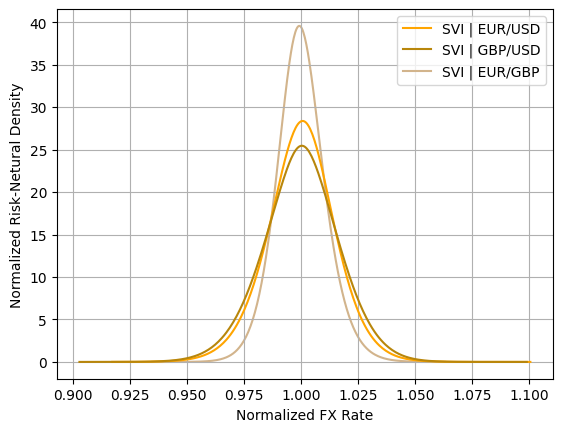

In [15]:
# Normalized SVI aproximated risk-netural densities (EUR/USD)

# Plot
plt.grid()
plt.plot(KX/FX, XF.density(KX/FX), color="orange", zorder=2)
plt.plot(KY/FY, YF.density(KY/FY), color="darkgoldenrod", zorder=3)
plt.plot(KZ/FZ, ZF.density(KZ/FZ), color="tan",  zorder=1)
plt.xlabel("Modifed Strike Rate", fontsize=10.5)
plt.ylabel("Normalized Risk-Netural Density", fontsize=10.5)
plt.legend(["SVI | EUR/USD", "SVI | GBP/USD", "SVI | EUR/GBP"], fontsize=10.5)

# save plot
plt.savefig('FX_SVI_normDensity.png')

Check densities are valid by checking they are normalized and have a forward price of 1 and integrate to 1

In [16]:
## Check density integrals for mu_X, mu_Y and mu_Z,

# Print integral of mu_X w.r.t x
print("int mu_X dx = ", np.sum(XF.density(KX/FX))*((KX/FX)[1] - (KX/FX)[0]))

# Print integral of mu_Y w.r.t y
print("int mu_Y dy = ", np.sum(YF.density(KY/FY))*((KY/FY)[1] - (KY/FY)[0]))

# Print integral of mu_Z w.r.t z
print("int mu_Z dz = ", np.sum(ZF.density(KZ/FZ))*((KZ/FZ)[1] - (KZ/FZ)[0]))

int mu_X dx =  0.99998925958372
int mu_Y dy =  0.9999992607937923
int mu_Z dz =  0.9999879751373167


In [17]:
## Check expecations of X, Y and Z

# Print expecation of X
print("E(X/F_X) = ", np.sum((KX/FX) * XF.density(KX/FX))*((KX/FX)[1] - (KX/FX)[0]))

# Print expectation of Y
print("E(Y/F_Y) = ", np.sum((KY/FY) * YF.density(KY/FY))*((KY/FY)[1] - (KY/FY)[0]))

# Print expectation of Z
print("E(Z/F_Z) = ", np.sum((KZ/FZ) * ZF.density(KZ/FZ))*((KZ/FZ)[1] - (KZ/FZ)[0]))

E(X/F_X) =  0.9999901885923889
E(Y/F_Y) =  0.9999993235455225
E(Z/F_Z) =  0.9999872438333143


## Sinkhorn Scheme (Joint Density Calibration)

In [18]:
# pre set parameters
n = 300
xb = np.array([0.9, 1.1])
yb = np.array([0.9, 1.1])
zb = np.array([0.94, 1.06])

# points and weights
points, weights = np.polynomial.legendre.leggauss(n)

# transformed points
x = ((xb[1]-xb[0])/2)*points + (xb[1]+xb[0])/2
y = ((yb[1]-yb[0])/2)*points + (yb[1]+yb[0])/2
z = np.linspace(zb[0], zb[1], n)

# jacobian 
Jx = (xb[1]-xb[0])/2
Jy = (yb[1]-yb[0])/2

# dfferent variables
xy_hat = x.reshape(n, 1)/y # x/y for u 
xy_bar = x/y.reshape(n, 1) # x/y for v
xz = x/z.reshape(n, 1) # x/z for w
x2z3 = x**2 / (z**3).reshape(n, 1) # x^2/z^3 for w

# initalile iteration

# u_0, v_0, w_0
u = v = w = 0

# 1st iteration

# u_1
u = 0 # int mu(y) dy

# v_1
v = 0 # int mu(x) dx

# w_1
def H(w):
    return (np.sum(np.exp(xz * w.reshape(n, 1)) * x2z3 * XF.density(x) * YF.density(xz) * Jx * weights, axis=1)) - ZF.density(z)
w = sp.optimize.root(H, np.repeat(0, n), method="lm").x
w_func = sp.interpolate.CubicSpline(z, w)

# 2nd iteration 

# u_2
u = - np.log(np.sum(np.exp(v + y * w_func(xy_hat)) * YF.density(y) * Jy * weights, axis=1))

# v_2
v = - np.log(np.sum(np.exp(u + y.reshape(n, 1) * w_func(xy_bar)) * XF.density(x) * Jx * weights, axis=1))
v_func = sp.interpolate.CubicSpline(y, v)

# w_2
def H(w):
    return np.sum(np.exp(u + v_func(xz) + xz * w.reshape(n, 1)) * x2z3 * XF.density(x) * YF.density(xz) * Jx * weights, axis=1) - ZF.density(z)
w = sp.optimize.root(H, w, method="lm").x
w_func = sp.interpolate.CubicSpline(z, w)

# nth iteration

# nth loop 
for i in range(48):

    # u_n
    u = - np.log(np.sum(np.exp(v + y * w_func(xy_hat)) * YF.density(y) * Jy * weights, axis=1))

    # v_nn
    v = - np.log(np.sum(np.exp(u + y.reshape(n, 1) * w_func(xy_bar)) * XF.density(x) * Jx * weights, axis=1))
    v_func = sp.interpolate.CubicSpline(y, v)

    # w_n
    def H(w):
        return np.sum(np.exp(u + v_func(xz) + xz * w.reshape(n, 1)) * x2z3 * XF.density(x) * YF.density(xz) * Jx * weights, axis=1) - ZF.density(z)
    w = sp.optimize.root(H, w, method="lm").x
    w_func = sp.interpolate.CubicSpline(z, w)


In [19]:
## mu_star

# mu* for X
def mu_starX(x, y):
    return np.exp(u.reshape(len(y), 1) + v + y * w_func(xy_hat)) * YF.density(y) * XF.density(x.reshape(len(y), 1))

# mu* for Y
def mu_starY(x,y):
    return np.exp(u + v.reshape(len(y), 1) + y.reshape(len(y), 1) * w_func(xy_bar)) * YF.density(y.reshape(len(y), 1)) * XF.density(x)

## Joint Density calibration Checks

In [23]:
## Initalize parmaters

# Set stike values 
KX = np.linspace(min(data.loc["Strike", "EUR/USD"]), max(data.loc["Strike", "EUR/USD"]), 8)
KY = np.linspace(min(data.loc["Strike", "GBP/USD"]), max(data.loc["Strike", "GBP/USD"]), 8)
KZ = np.linspace(min(data.loc["Strike", "EUR/GBP"]), max(data.loc["Strike", "EUR/GBP"]), 8)

# Set stike values 
KX_ = np.linspace(min(data.loc["Strike", "EUR/USD"]), max(data.loc["Strike", "EUR/USD"]), 100)
KY_ = np.linspace(min(data.loc["Strike", "GBP/USD"]), max(data.loc["Strike", "GBP/USD"]), 100)
KZ_ = np.linspace(min(data.loc["Strike", "EUR/GBP"]), max(data.loc["Strike", "EUR/GBP"]), 100)

## Root finding for implied volaitlity

# root finding functions for X and Y
def findSigmaX(sig):
    return np.sum(np.maximum(x - (KX.reshape(len(KX), 1)/FX), 0) * np.sum(mu_starX(x, y) * Jy * weights, axis=1) * Jx * weights, axis=1) - bsCall(1, KX/FX, 1/12, sig, 0)
def findSigmaY(sig):
    return np.sum(np.maximum(y - (KY.reshape(len(KY), 1)/FY), 0) * np.sum(mu_starY(x, y) * Jx * weights, axis=1) * Jy * weights, axis=1) - bsCall(1, KY/FY, 1/12, sig, 0)

# root finding for X and Y
sigX = sp.optimize.root(findSigmaX, np.repeat(0.03, 8)).x
sigY = sp.optimize.root(findSigmaY, np.repeat(0.03, 8)).x

# root finding for Z
sigZ = []
for i in range(8):
    
    # root finding function for Z
    def findSigmaZ(sig):
        A = np.sum(np.sum( y.reshape(len(y),1) * np.maximum((x/y.reshape(len(y), 1))- (KZ/FZ)[i], 0) * mu_starY(x, y) * Jx * weights, axis=1) * Jy * weights)
        return A - bsCall(1, (KZ/FZ)[i], 1/12, sig, 0)
    
    sigZ.append(sp.optimize.root(findSigmaZ, 0.03).x)

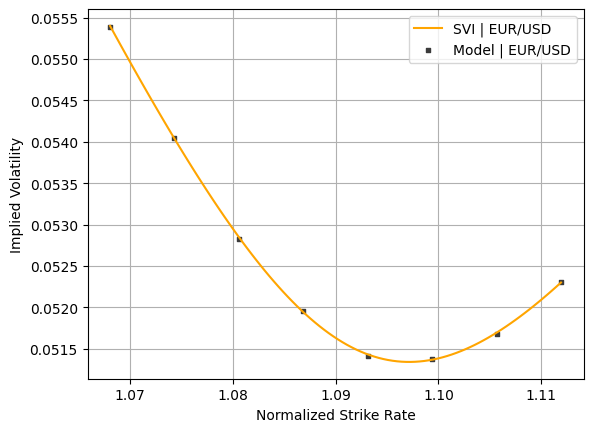

In [24]:
## SVI Density (EUR/USD)

# Plot
plt.grid()
plt.plot(KX_, impVol(FX, KX_, 1/12, prm["EUR/USD"]), zorder=2, color="orange")
plt.scatter(KX, sigX, color="#3b3b3b", marker="s", s=12.5, zorder=1)
plt.xlabel("Modifed Strike Rate", fontsize=10.5)
plt.ylabel("Implied Volatility", fontsize=10.5)
plt.legend(["SVI | EUR/USD", "Model | EUR/USD"], fontsize=10.5)

plt.savefig('EU_SVI_Mdl.png')

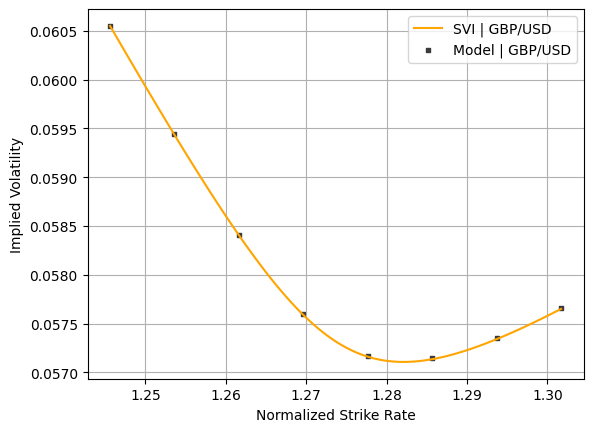

In [25]:
## SVI Density (GBP/USD)

# Plot
plt.grid()
plt.plot(KY_, impVol(FY, KY_, 1/12, prm["GBP/USD"]), zorder=2, color="orange")
plt.scatter(KY, sigY, color="#3b3b3b", marker="s", s=12.5, zorder=1)
plt.xlabel("Modifed Strike Rate", fontsize=10.5)
plt.ylabel("Implied Volatility", fontsize=10.5)
plt.legend(["SVI | GBP/USD", "Model | GBP/USD"], fontsize=10.5)

plt.savefig('GU_SVI_Mdl.png')

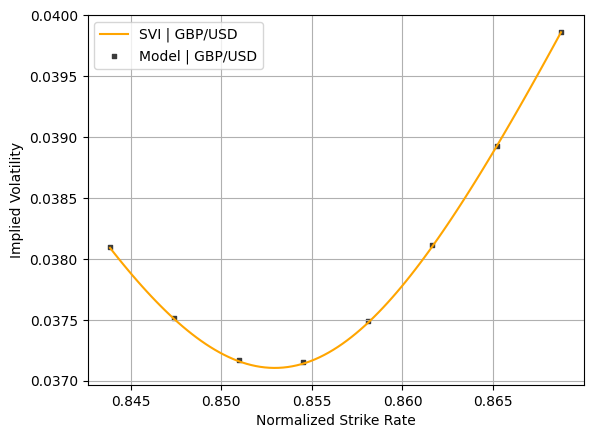

In [26]:
## SVI Density (EUR/GBP)

# Plot
plt.grid()
plt.plot(KZ_, impVol(FZ, KZ_, 1/12, prm["EUR/GBP"]), zorder=2, color="orange")
plt.scatter(KZ, sigZ, color="#3b3b3b", marker="s", s=12.5, zorder=1)
plt.xlabel("Modifed Strike Rate", fontsize=10.5)
plt.ylabel("Implied Volatility", fontsize=10.5)
plt.legend(["SVI | GBP/USD", "Model | GBP/USD"], fontsize=10.5)

plt.savefig('EG_SVI_Mdl.png')

## Additonal graphs

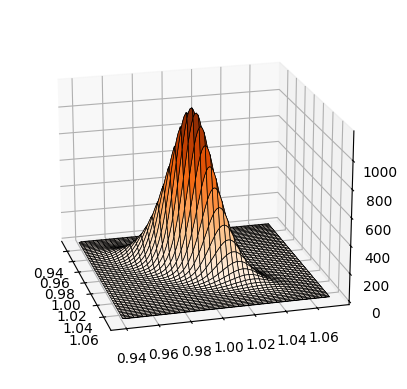

In [20]:
ax_X = np.tile(x, (len(x), 1))
ax_Y = np.tile(y.reshape(len(y), 1), (1, len(y)))
ax_Z = mu_starX(x, y)

ax_X[ax_X < 0.93] = np.nan
ax_Z[ax_X < 0.93] = np.nan

ax_X[ax_X > 1.072] = np.nan
ax_Z[ax_X > 1.072] = np.nan

ax_Y[ax_Y < 0.94] = np.nan
ax_Z[ax_Y < 0.94] = np.nan

ax_Y[ax_Y > 1.071] = np.nan
ax_Z[ax_Y > 1.071] = np.nan

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(ax_X, ax_Y, ax_Z, cmap="Oranges", lw=0.5, rstride=3, cstride=3, edgecolor="black", shade=False, antialiased=True)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("mu(x, y)")

ax.view_init(elev=20., azim=-15, roll=0)

plt.savefig('FX_Joint_Density.png')

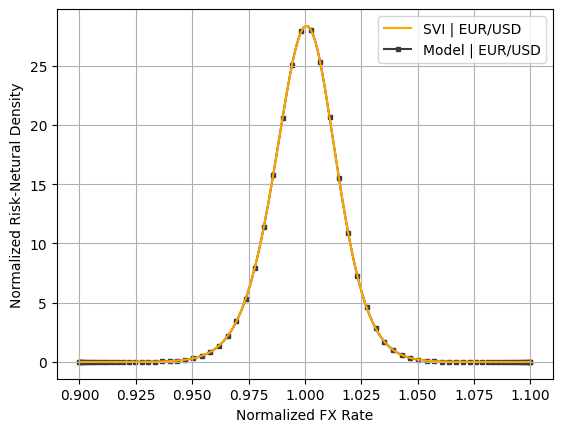

In [21]:
## plot EUR/USD marginal from the joint denisty mu*

# Marginal Density (EUR/USD)
plt.grid()
plt.plot(x, XF.density(x), zorder=2, color="orange")
plt.plot(x, np.sum(mu_starX(x, y) * Jy * weights, axis=1), color="#3b3b3b", marker="s", markersize=3.5, markevery=4, zorder=1)
plt.xlabel("Normalized FX Rate", fontsize=10.5)
plt.ylabel("Normalized Risk-Netural Density", fontsize=10.5)
plt.legend(["SVI | EUR/USD", "Model | EUR/USD"], fontsize=10.5)

plt.savefig('EU_SVI_Mdl_Density.png')

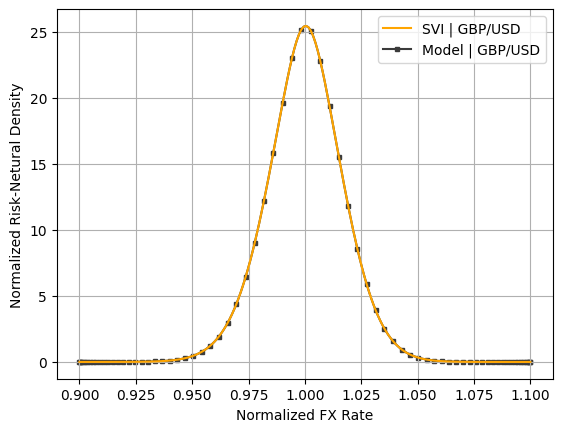

In [22]:
## plot GBP/USD marginal from the joint denisty mu*

# SVI Density (GBP/USD)
plt.grid()
plt.plot(y, YF.density(y), zorder=2, color="orange")
plt.plot(y, np.sum(mu_starY(x, y) * Jx * weights, axis=1), color="#3b3b3b", marker="s", markersize=3.5, markevery=4, zorder=1)
plt.xlabel("Modifed Strike Rate", fontsize=10.5)
plt.ylabel("Normalized Risk-Netural Density", fontsize=10.5)
plt.legend(["SVI | GBP/USD", "Model | GBP/USD"], fontsize=10.5)

plt.savefig('GU_SVI_Mdl_Density.png')

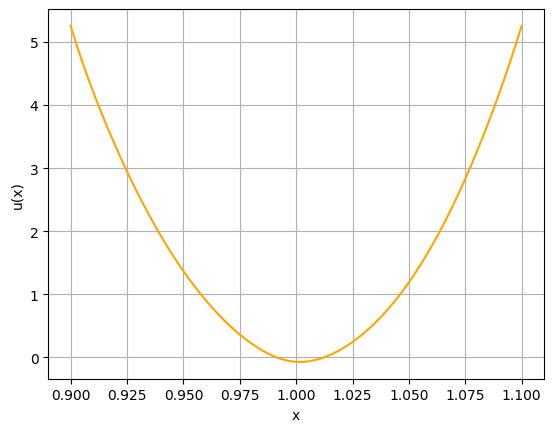

In [27]:
# plot of u function 

plt.grid()
plt.plot(x, u, color="orange")
plt.xlabel("x", fontsize=10.5)
plt.ylabel("u(x)", fontsize=10.5)

plt.savefig('u_x.png')

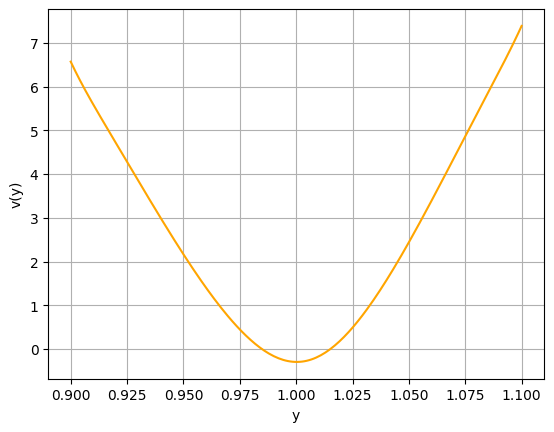

In [28]:
# plot of v function

plt.grid()
plt.plot(y, v, color="orange")
plt.xlabel("y", fontsize=10.5)
plt.ylabel("v(y)", fontsize=10.5)

plt.savefig('v_y.png')

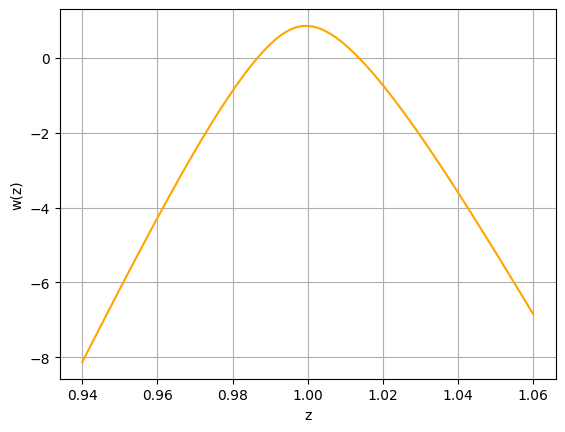

In [29]:
# plot of w function

plt.grid()
plt.plot(z, w, color="orange")
plt.xlabel("z", fontsize=10.5)
plt.ylabel("w(z)", fontsize=10.5)

plt.savefig('w_z.png')

## Exotic pricing

price a basket call option which pays: 

$$ \text{payoff} = (\frac{1}{2}(X + Y) - 1)^+ $$

In [30]:
basket_price = np.sum(np.sum(np.maximum(0.5 * ( np.tile(x, (len(x), 1)) + np.tile(y.reshape(len(y), 1), (1, len(y))) ) - 1, 0) * mu_starY(x, y) * Jx * weights, axis=1) * Jy * weights)
print(basket_price)

0.005885415997783902


price a quanto call option which pays: 

$$ \text{payoff} = (\frac{X}{Y} - 1)^+ $$


In [31]:
quanto_price = np.sum(np.sum(np.maximum((x/y.reshape(len(y), 1))- 1, 0) * mu_starY(x, y) * Jx * weights, axis=1) * Jy * weights)
print(quanto_price)

0.004329584559771377


price a best-of (rainbow) option which pays: 

$$ \text{payoff} = (\text{max}(X, Y) - 1)^+ $$


In [38]:
rainbow_price = np.sum(np.sum(np.maximum((np.maximum(np.tile(x, (len(x), 1)), np.tile(y.reshape(len(y), 1), (1, len(y)))) - 1), 0) * mu_starY(x, y) * Jx * weights, axis=1) * Jy * weights)
print(rainbow_price)

0.008430286530178762


price a quadratric option which pays: 

$$ \text{payoff} = (X - Y)^2 $$

In [ ]:
quadratic_price = np.sum(np.sum( y.reshape(len(y),1) * ( np.tile(x, (len(x), 1)) - np.tile(y.reshape(len(y), 1), (1, len(y))) )**2 * mu_starY(x, y) * Jx * weights, axis=1) * Jy * weights)
print(quadratic_price)

0.00012179249391039391
